# День добрый
___
### Представляю твоему вниманию проектную работу
## <ins>"Прогнозирование количества заказов такси"</ins>
___
### Данное исследование разделим на несколько шагов:
___
<a id='top'></a>
1. [Постановка задачи](#1)
2. [Общая информация о данных](#2)
3. [Предобработка данных](#3)
4. [Анализ данных](#4)
5. [Подготовка признаков](#5)
6. [Модели](#6)
 * [Константная модель](#6.1)
 * [Остальные модели](#6.2)
7. [Вывод](#7)

<a id='1'></a>

## 1. Постановка задачи

С помощью моделей машинного обучения предскажем количство заказов такси на следующий час для оптимизации работы компании "Чётенькое такси".

<a id='2'></a>

## 2. Общая информация о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
try:
    df = pd.read_csv("taxi.csv")
except:
    try:
        df = pd.read_csv("/datasets/taxi.csv")
    except:
        df = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv")

In [3]:
display(df.head())
print()
print(df.info())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


В нашем распоряжении таблица с информацией о количестве заказов за промежутки времени в 10 минут. Данных не много, пропусков нет. Нужно будет столбец с датой и временем перевести в нужный формат и сделать его индексом и проверить на аномалии данные.

<a id='3'></a>

## 3. Предобработка данных<div align=right>[To top](#top)</div>

Сделаем столбец `datetime` индеском и отсортируем по времени.

In [4]:
# переводим в нужный формат дату и время

df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df = df.set_index('datetime')
df = df.sort_index()

In [6]:
# проверим правильно ли отсортировалось время

df.index.is_monotonic

True

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим как распределены данные на гистограмме, нет ли явных аномалий.

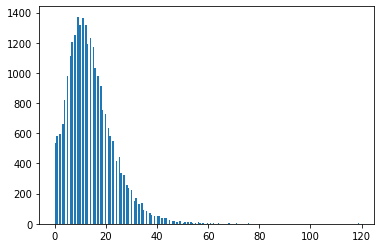

In [8]:
df['num_orders'].hist(bins=200, grid=False)

Каких-то явных аномалий не видно.

Сделаем ресемплирование данных с шагом в один час. В качестве агрегации промежуточных данных возьмем сумму.

In [9]:
df = df.resample('1H').sum()

<a id='4'></a>

## 4. Анализ данных<div align=right>[To top](#top)</div>

Отобразим ряд на графике:

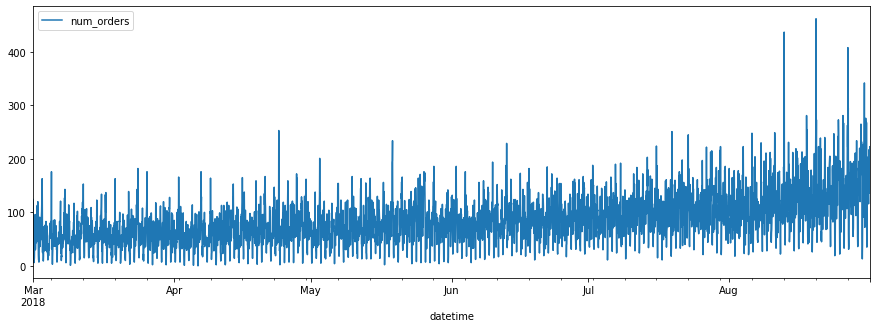

In [10]:
df.plot(figsize=(15, 5))

По графику видим, что ряд является нестационарным, т.к. меняется его среднее и дисперсия.

С помощью функции seasonal_decompose() из библиотеки statsmodels разложим наш ряд на составляющие тренд, сезонность и остатки.

In [11]:
decomposed = seasonal_decompose(df)

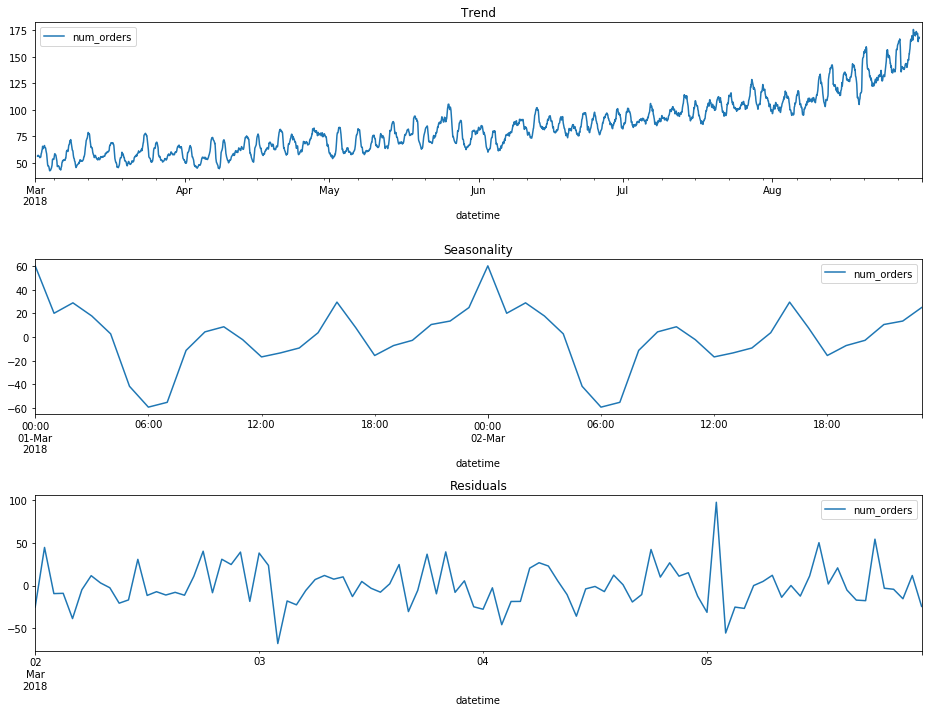

In [12]:
plt.figure(figsize=(13, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
# возьмем данные за 2 дня чтобы можно было разглядеть периодические колебания
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-03-02':'2018-03-05'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Из графиков видим, что наблюдается устойчивый рост числа заказов такси с марта по август включительно.  
По графику сезонности можно выявить периодические колебания числа заказов такси, преиод составляет 24 часа. Можно отметить резкий спад с полуночи до шести утра и плавный неравномерный рост с шести утра до полуночи.  
Также видим много шумов на графике остатков.

<a id='5'></a>

## 5. Подготовка признаков<div align=right>[To top](#top)</div>

Определим функцию `features_maker`, которая будет создавать признаки, необходимые для обучения моделей. На вход будет принимать данные, значение максимального сдвига и значение размера окна для скользящего среднего. Также создадим календарные признаки.

In [13]:
def features_maker(data, max_lag, rolling_mean_size):
    data_2 = data.copy()
    
    data_2['month'] = data_2.index.month
    data_2['day'] = data_2.index.day
    data_2['day_of_week'] = data_2.index.dayofweek
    data_2['hour'] = data_2.index.hour
    
    for lag in range(1, max_lag + 1):
        data_2['lag_{}'.format(lag)] = data_2['num_orders'].shift(lag)
        
    data_2['rolling_mean'] = data_2['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_2

<a id='6'></a>

## 6. Модели

<a id='6.1'></a>

### 6.1 Константная модель

Создадим две базовые модели. Одна будет предсказывать значения медианной, другая отстающим значением ряда. Выберем лучшую для проверки на вменяемость остальных моделей.

In [14]:
train_const, test_const = train_test_split(df, shuffle=False, test_size=0.1)

predictions_const_median = np.ones(test_const.shape) * train_const['num_orders'].median()

predictions_const_shift = test_const.shift()
predictions_const_shift.iloc[0] = train_const.iloc[-1]

print("RMSE при прогнозе медианой:", mean_squared_error(test_const, predictions_const_median) ** 0.5)
print()
print("RMSE при прогнозе предыдущим значением ряда:", mean_squared_error(test_const, predictions_const_shift) ** 0.5)

RMSE при прогнозе медианой: 87.15277582981295

RMSE при прогнозе предыдущим значением ряда: 58.856486242815066


Константная модель, прогнозирующая отстающим значением ряда, показала лучший результат с RMSE = 59. Это будет наш `baseline`.

<a id='6.2'></a>

### 6.2 Остальные модели

Используем следующие модели машинного обучения: Tree, Random forest, Linear regression, CatBoost и LightGBM.

Подберем параметры через GridSearchCV.

In [15]:
# создаем объект tscv
# используем TimeSeriesSplit т.к. во временных рядах нельзя использовать стандартную кросс-валидацию

tscv = TimeSeriesSplit(n_splits=2)

In [16]:
# для перебора гиперпараметров используем ограниченный набор чисел чтобы ускорить время выполнения циклов

tree_Grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=237),
                         param_grid={'max_depth':np.arange(6, 11, 2)},
                         scoring='neg_mean_squared_error',
                         cv=tscv,
                         n_jobs=2)

In [17]:
rf_Grid = GridSearchCV(estimator=RandomForestRegressor(random_state=237),
                       param_grid={'n_estimators':np.arange(90, 101, 3), 'max_depth':np.arange(21, 28, 3)},
                       scoring='neg_mean_squared_error',
                       cv=tscv,
                       n_jobs=2)

In [18]:
cb_Grid = GridSearchCV(estimator=CatBoostRegressor(learning_rate=0.1, verbose=False),
                       param_grid={'iterations':np.arange(100, 150, 10), 'depth':np.arange(6, 9, 2)},
                       scoring='neg_mean_squared_error',
                       cv=tscv,
                       n_jobs=2)

In [19]:
lg_Grid = GridSearchCV(estimator=LGBMRegressor(),
                       param_grid={'num_leaves':np.arange(50, 63, 2),
                                   'max_depth':np.arange(4, 7, 2),
                                   'n_estimators':np.arange(100, 150, 10)},
                       scoring='neg_mean_squared_error',
                       cv=tscv,
                       n_jobs=2)

Будем в циклах менять значения максимального сдвига и размер окна для скользящего среднего.  
Внутри циклов в данных будут появляться новые признаки, данные будут делиться на обучающую и тестовую выборки, у модели будут перебираться гиперпараметры и лучший результат пойдет на проверку на тестовой выборке.  
Все результаты и гиперпараметры будут заноситься в списки, из которых потом соберем датафрейм и выделим строку с наименьшим RMSE.

In [20]:
%%time

# определим списки для переменных, чтобы потом собрать все в датафрейм и выявить лучший результат
score_tree_list = []
max_depth_tree_list = []

score_rf_list = []
n_estimators_rf_list = []
max_depth_rf_list = []

score_lr_list = []

score_cb_list = []
iterations_cb_list = []
max_depth_cb_list = []

score_lg_list = []
num_leaves_lg_list = []
max_depth_lg_list = []
n_estimators_lg_list = []

lag_list = []
rolling_mean_size_list = []


for lag in range(1, 12, 2):
    # для контроля засечем время выполнения большого цикла
    start = time.time()
    
    for roll_size in range(1, 12, 2):
        
        # преобразуем данные функцией
        df_fm = features_maker(df, lag, roll_size)
        
        # делим на обучающую и тестовую выборки и удаляем пропуски
        train, test = train_test_split(df_fm, shuffle=False, test_size=0.1)
        train = train.dropna()
        
        # определяем признаки и целевой признак
        features_train = train.drop('num_orders', axis=1)
        features_test = test.drop('num_orders', axis=1)
        target_train = train['num_orders']
        target_test = test['num_orders']
        
        # стандартизируем значения
        scaler = StandardScaler()
        scaler.fit(features_train)
        features_train = scaler.transform(features_train)
        features_test = scaler.transform(features_test)
        
        # tree
        #=====
        tree_Grid.fit(features_train, target_train)
        best_params_tree = tree_Grid.best_params_
        
        model_tree = DecisionTreeRegressor(max_depth=best_params_tree['max_depth'], random_state=237)
        model_tree.fit(features_train, target_train)
        predictions_tree = model_tree.predict(features_test)
        score_tree = mean_squared_error(target_test, predictions_tree) ** 0.5
        
        # Random forest
        #==============
        rf_Grid.fit(features_train, target_train)
        best_params_rf = rf_Grid.best_params_
        
        model_rf = RandomForestRegressor(n_estimators=best_params_rf['n_estimators'],
                                         max_depth=best_params_rf['max_depth'],
                                         random_state=237)
        
        model_rf.fit(features_train, target_train)
        predictions_rf = model_rf.predict(features_test)
        score_rf = mean_squared_error(target_test, predictions_rf) ** 0.5
        
        # Linear regression
        #==================
        model_lr = LinearRegression()
        model_lr.fit(features_train, target_train)
        predictions_lr = model_lr.predict(features_test)
        score_lr = mean_squared_error(target_test, predictions_lr) ** 0.5
        
        # CatBoost
        #=========
        cb_Grid.fit(features_train, target_train)
        best_params_cb = cb_Grid.best_params_
        
        model_cb = CatBoostRegressor(iterations=best_params_cb['iterations'],
                                     depth=best_params_cb['depth'],
                                     learning_rate=0.1,
                                     verbose=False)
        
        model_cb.fit(features_train, target_train)
        predictions_cb = model_cb.predict(features_test)
        score_cb = mean_squared_error(target_test, predictions_cb) ** 0.5
        
        #LightGBM
        #========
        lg_Grid.fit(features_train, target_train)
        best_params_lg = lg_Grid.best_params_
        
        model_lg = LGBMRegressor(num_leaves=best_params_lg['num_leaves'],
                                 max_depth=best_params_lg['max_depth'],
                                 n_estimators=best_params_lg['n_estimators'],
                                 n_jobs=2)
        
        model_lg.fit(features_train, target_train)
        predictions_lg = model_lg.predict(features_test)
        score_lg = mean_squared_error(target_test, predictions_lg) ** 0.5
                
        # lists.append
        #=============
        lag_list.append(lag)
        rolling_mean_size_list.append(roll_size)
        
        max_depth_tree_list.append(best_params_tree["max_depth"])
        score_tree_list.append(score_tree)
        
        n_estimators_rf_list.append(best_params_rf['n_estimators'])
        max_depth_rf_list.append(best_params_rf["max_depth"])
        score_rf_list.append(score_rf)
        
        score_lr_list.append(score_lr)
        
        iterations_cb_list.append(best_params_cb['iterations'])
        max_depth_cb_list.append(best_params_cb['depth'])
        score_cb_list.append(score_cb)
        
        num_leaves_lg_list.append(best_params_lg['num_leaves'])
        max_depth_lg_list.append(best_params_lg['max_depth'])
        n_estimators_lg_list.append(best_params_lg['n_estimators'])
        score_lg_list.append(score_lg)
        
    stop = time.time()
    print('Время большого цикла номер', lag, 'составляет', stop - start)

Время большого цикла номер 1 составляет 102.80018281936646
Время большого цикла номер 3 составляет 116.0667188167572
Время большого цикла номер 5 составляет 132.54666209220886
Время большого цикла номер 7 составляет 147.87668132781982
Время большого цикла номер 9 составляет 163.83701419830322
Время большого цикла номер 11 составляет 179.94794487953186
Wall time: 14min 3s


In [21]:
# собираем данные в таблицу

df_results = pd.DataFrame({'lag':lag_list,
                           'rolling_mean_size':rolling_mean_size_list,
                           
                           'max_depth_tree':max_depth_tree_list,
                           'score_tree':score_tree_list,
                           
                           'n_estimators_rf':n_estimators_rf_list,
                           'max_depth_rf':max_depth_rf_list,
                           'score_rf':score_rf_list,
                           
                           'score_lr':score_lr_list,
                           
                           'iterations_cb':iterations_cb_list,
                           'max_depth_cb':max_depth_cb_list,
                           'score_cb':score_cb_list,
                           
                           'num_leaves_lg':num_leaves_lg_list,
                           'max_depth_lg':max_depth_lg_list,
                           'n_estimators_lg':n_estimators_lg_list,
                           'score_lg':score_lg_list})

<a id='7'></a>

## 7. Вывод<div align=right>[To top](#top)</div>

В таблице ниже представлены результаты работы моделей по предсказанию количества заказов такси на следующий час:

In [22]:
mae_best_list = [
    df_results.loc[df_results['score_tree'] == df_results['score_tree'].min(), 'score_tree'].values[0],
    df_results.loc[df_results['score_rf'] == df_results['score_rf'].min(), 'score_rf'].values[0],
    df_results.loc[df_results['score_lr'] == df_results['score_lr'].min(), 'score_lr'].values[0],
    df_results.loc[df_results['score_cb'] == df_results['score_cb'].min(), 'score_cb'].values[0],
    df_results.loc[df_results['score_lg'] == df_results['score_lg'].min(), 'score_lg'].values[0]
]

lag_best_list = [
    df_results.loc[df_results['score_tree'] == df_results['score_tree'].min(), 'lag'].values[0],
    df_results.loc[df_results['score_rf'] == df_results['score_rf'].min(), 'lag'].values[0],
    df_results.loc[df_results['score_lr'] == df_results['score_lr'].min(), 'lag'].values[0],
    df_results.loc[df_results['score_cb'] == df_results['score_cb'].min(), 'lag'].values[0],
    df_results.loc[df_results['score_lg'] == df_results['score_lg'].min(), 'lag'].values[0]
]

rolling_mean_size_best_list = [
    df_results.loc[df_results['score_tree'] == df_results['score_tree'].min(), 'rolling_mean_size'].values[0],
    df_results.loc[df_results['score_rf'] == df_results['score_rf'].min(), 'rolling_mean_size'].values[0],
    df_results.loc[df_results['score_lr'] == df_results['score_lr'].min(), 'rolling_mean_size'].values[0],
    df_results.loc[df_results['score_cb'] == df_results['score_cb'].min(), 'rolling_mean_size'].values[0],
    df_results.loc[df_results['score_lg'] == df_results['score_lg'].min(), 'rolling_mean_size'].values[0]
]

max_depth_best_list = [
    df_results.loc[df_results['score_tree'] == df_results['score_tree'].min(), 'max_depth_tree'].values[0],
    df_results.loc[df_results['score_rf'] == df_results['score_rf'].min(), 'max_depth_rf'].values[0],
    '/////',
    df_results.loc[df_results['score_cb'] == df_results['score_cb'].min(), 'max_depth_cb'].values[0],
    df_results.loc[df_results['score_lg'] == df_results['score_lg'].min(), 'max_depth_lg'].values[0],
]

n_estimators_best_list = [
    '/////',
    df_results.loc[df_results['score_rf'] == df_results['score_rf'].min(), 'n_estimators_rf'].values[0],
    '/////',
    '/////',
    df_results.loc[df_results['score_lg'] == df_results['score_lg'].min(), 'n_estimators_lg'].values[0]
]

iterations_best_list = [
    '/////',
    '/////',
    '/////',
    df_results.loc[df_results['score_cb'] == df_results['score_cb'].min(), 'iterations_cb'].values[0],
    '/////',
]

num_leaves_best_list = [
    '/////',
    '/////',
    '/////',
    '/////',
    df_results.loc[df_results['score_lg'] == df_results['score_lg'].min(), 'num_leaves_lg'].values[0]
]

df_results_final = pd.DataFrame({'RMSE':mae_best_list,
                                 'Lag':lag_best_list,
                                 'Rolling_mean_size':rolling_mean_size_best_list,
                                 'Max_depth':max_depth_best_list,
                                 'N_estimators':n_estimators_best_list,
                                 'Iterations':iterations_best_list,
                                 'Num_leaves':num_leaves_best_list
                                },
                               
                                index=['Tree',
                                       'Random forest',
                                       'Linear regression',
                                       'CatBoost',
                                       'LightGBM'])

df_results_final = df_results_final.round(2)
df_results_final

,RMSE,Lag,Rolling_mean_size,Max_depth,N_estimators,Iterations,Num_leaves
Tree,46.89,9,5,8,/////,/////,/////
Random forest,43.11,11,3,24,99,/////,/////
Linear regression,52.23,11,11,/////,/////,/////,/////
CatBoost,42.50,1,9,6,/////,130,/////
LightGBM,40.78,1,9,4,120,/////,50


Все модели прошли тест на адекватность.

Самый лучший результат показала модель LightGBM, ее абсолютная ошибка составляет 29,95. Можем предложить заказчику использовать данную модель для прогнозирования числа заказов такси на следующий час.

По таблице финальных результатов также можно отметить, что "деревянным" моделям требуется большее количество признаков для получения лучшего результата, что в свою очередь влечет за собой увеличение затрачиваемого времени на обучение и предсказание этих моделей.

Спасибо за внимание:)